# Bidirectional Encoder Representations from Transformers (BERT)





In [1]:
# Montar drive google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install transformers

In [9]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

# Transformers do Hugging Face
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW
from transformers import get_linear_schedule_with_warmup
import time
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Baixar modelo de https://huggingface.co/neuralmind/bert-base-portuguese-cased
BERT_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
# BERT_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'


class BertClassificationModel(nn.Module):
    def __init__(self):
        super(BertClassificationModel, self).__init__()
        self.bert_path = BERT_MODEL_NAME
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.bert_drop=nn.Dropout(0.3)
        self.out = nn.Linear(768, 2)
        # self.out = nn.Linear(1024, 2)

    def forward(self, ids, mask):
        outputs = self.bert(input_ids=ids, attention_mask=mask)
        rh=self.bert_drop(outputs.pooler_output)
        return self.out(rh)


class CudaDevice:
    def get_device(self, force_cpu=False):
        if not force_cpu and torch.cuda.is_available():
            device = torch.device("cuda")
            print('Existe(m) %d GPU(s) disponíveis.' %
                  torch.cuda.device_count())
            print('A GPU', torch.cuda.get_device_name(0), 'será usada.')
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device("cpu")
        return device


class BertDataset(Dataset):

    def __init__(self,
                 data,
                 tokenizer,
                 max_len=None,
                 max_size_dataset=None,
                 ):
        self.tokenizer = tokenizer
        self.data_raw = data
        self.max_len = max_len
        self.max_size_dataset = max_size_dataset
        self.data, self.label = self.process_data()


    def process_data(self):

        print('Carregando os dados do dataset')
        df = self.data_raw.copy()

        if self.max_len:
            print(f'Limitando textos em {self.max_len} caracteres!')
            df['text'] = df['text'].apply(lambda x: x[:self.max_len] if len(x) > self.max_len else x)

        train = df.copy()

        if(self.max_size_dataset):
            print(f'Limitando dataset em {self.max_size_dataset} registros!')
            train = train.loc[0:self.max_size_dataset, :]

        train = train.reindex(np.random.permutation(train.index))
        train['text'] = train['text'].apply(self.clean_txt)
        return train['text'].values, train['label'].values

    def clean_txt(self, text):
        # text = re.sub("'", "", text)
        # text = re.sub("(\\W)+", " ", text)
        return text

    def __getitem__(self, idx):

        text = str(self.data[idx])
        target = int(self.label[idx])

        data = self.tokenizer.encode_plus(
            text,
            max_length=512,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_overflowing_tokens=False,
            truncation=True,
            return_tensors='pt')

        return({
            'ids': data['input_ids'].long(),
            'mask': data['attention_mask'].int(),
            'targets': torch.tensor([target], dtype=torch.int),
            'texto': text.strip(),
        })

    def __len__(self):

        """ Return data length """
        return self.label.shape[0]


def my_collate1(batches):
    return [{key: value for key, value in batch.items()} for batch in batches]


def loss_fun(outputs, targets):
    loss = nn.CrossEntropyLoss()
    return loss(outputs, targets)


def evaluate(target, predicted):

    true_label_mask = [1 if (np.argmax(x)-target[i]) ==
                       0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction-true_prediction
    accuracy = true_prediction/nb_prediction

    roc = roc_auc_score(target, predicted[:, 1])

    return{
        "accuracy": accuracy,
        "nb exemple": len(target),
        "true_prediction": true_prediction,
        "false_prediction": false_prediction,
        "roc_auc": roc
    }


def train_loop(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    t0 = time.time()
    losses = []
    for batch_idx, batch in enumerate(data_loader):
        ids = [data["ids"] for data in batch]
        mask = [data["mask"] for data in batch]
        targets = [data["targets"] for data in batch]

        ids = torch.cat(ids)
        mask = torch.cat(mask)
        targets = torch.cat(targets)

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask)
        loss = loss_fun(outputs, targets)
        loss.backward()
        model.float()
        optimizer.step()
        if scheduler:
            scheduler.step()
        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), loss = {np.mean(losses[-10:]):.4f}, time = {time.time()-t0:.2f} seconds ___")
            t0 = time.time()
    return losses


def eval_loop(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    losses = []

    for batch_idx, batch in tqdm.tqdm(enumerate(data_loader)):
        ids = [data["ids"] for data in batch]
        mask = [data["mask"] for data in batch]
        targets = [data["targets"] for data in batch]

        ids = torch.cat(ids)
        mask = torch.cat(mask)
        targets = torch.cat(targets)

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)

        with torch.no_grad():
            outputs = model(ids=ids, mask=mask)
            loss = loss_fun(outputs, targets)
            losses.append(loss.item())

        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(torch.softmax(outputs, dim=1).cpu().detach().numpy())

    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses

########################################################################################
# variáveis globais
########################################################################################
device = CudaDevice().get_device(force_cpu=False)

TRAIN_BATCH_SIZE = 4
EPOCH = 3
validation_split = .2
shuffle_dataset = True
random_seed = 42
RANDOM_STATE = 42
MAX_LEN = None
MAX_SIZE_DATASET = None

Existe(m) 1 GPU(s) disponíveis.
A GPU Tesla T4 será usada.


In [10]:
########################################################################################
# dataset empenhos liquidados
########################################################################################
dataset = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado - balanceado.json')
train_raw = dataset[['descricao', 'fato_gerador']]
train_raw.columns = ['text', 'label']
train_raw['label'] = train_raw['label'].apply(lambda x: 1 if x == 'Sim' else 0)


########################################################################################
# se quiser trabalhar com amostra menor
########################################################################################

SAMPLE_SIZE = 8000
train_raw = train_raw.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
#s_labels = train_raw['label'].value_counts(normalize=True).sort_index()
#train_raw = pd.concat([
#    train_raw[train_raw['label']==0].sample(int(SAMPLE_SIZE * s_labels[0]), random_state=random_seed), # ~0.427427
#    train_raw[train_raw['label']==1].sample(int(SAMPLE_SIZE * s_labels[1]), random_state=random_seed), # ~0.572573
#])

print('Formato:', train_raw.shape)
train_raw.head()

Formato: (8000, 2)


,text,label
17751,Serviços De Reprodução De Mídias Educacionais ...,1
1072,Serviços De Transporte De Materiais De Infra E...,1
26045,Serviços De Arborização Nos Espaços Publicos D...,1
2531,Serviços Como Agente Administrativo No Posto D...,1
17605,Serviços De Limpeza E Furos Igarapes Na Local...,1


In [11]:
print('Loading BERT tokenizer...')

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

X_train, X_test, y_train, y_test = train_test_split(
    train_raw[['text']],
    train_raw.label,
    test_size=0.3,
    stratify=train_raw.label,
    random_state=random_seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train[['text']],
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=random_seed
)

train_dataset = BertDataset(
    data=pd.concat([X_train, y_train], axis=1),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    max_size_dataset=MAX_SIZE_DATASET,
)

val_dataset = BertDataset(
    data=pd.concat([X_val, y_val], axis=1),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    max_size_dataset=MAX_SIZE_DATASET,
)

test_dataset = BertDataset(
    data=pd.concat([X_test, y_test], axis=1),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    max_size_dataset=MAX_SIZE_DATASET,
)

train_data_loader = DataLoader(
  train_dataset,
  batch_size=TRAIN_BATCH_SIZE,
  collate_fn=my_collate1
)

valid_data_loader = DataLoader(
  val_dataset,
  batch_size=TRAIN_BATCH_SIZE,
  collate_fn=my_collate1
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=TRAIN_BATCH_SIZE,
  collate_fn=my_collate1
)

lr=3e-5
num_training_steps=int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=BertClassificationModel().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
batches_probs=[]

for epoch in range(EPOCH):
    t0 = time.time()
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp = eval_loop(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(np.mean(val_losses_tmp))
    batches_losses.append(np.mean(batches_losses_tmp))
    batches_probs.append(output)
    #torch.save(model, f"drive/MyDrive/Modelos/model_epoch_{epoch+1}.pt")
    torch.save(model, f"drive/MyDrive/model_epoch_{epoch+1}.pt")

Loading BERT tokenizer...
Carregando os dados do dataset
Carregando os dados do dataset
Carregando os dados do dataset

=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1120 (0.00%), loss = 0.6524, time = 0.47 seconds ___
___ batch index = 100 / 1120 (8.93%), loss = 0.0921, time = 41.76 seconds ___
___ batch index = 200 / 1120 (17.86%), loss = 0.1276, time = 40.25 seconds ___
___ batch index = 300 / 1120 (26.79%), loss = 0.0434, time = 40.55 seconds ___
___ batch index = 400 / 1120 (35.71%), loss = 0.1452, time = 40.44 seconds ___
___ batch index = 500 / 1120 (44.64%), loss = 0.0215, time = 40.46 seconds ___
___ batch index = 600 / 1120 (53.57%), loss = 0.0449, time = 40.49 seconds ___
___ batch index = 700 / 1120 (62.50%), loss = 0.0161, time = 40.48 seconds ___
___ batch index = 800 / 1120 (71.43%), loss = 0.0229, time = 40.47 seconds ___
___ batch index = 900 / 1120 (80.36%), loss = 0.2714, time = 40.49 seconds ___
___ batch index = 1000 / 1120 (89.29%), loss = 0.0

280it [00:37,  7.47it/s]


==> evaluation : avg_loss = 0.04, time : 37.49 sec

=====>	{'accuracy': 0.9875, 'nb exemple': 1120, 'true_prediction': 1106, 'false_prediction': 14, 'roc_auc': 0.9989870977893164}

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1120 (0.00%), loss = 0.0067, time = 0.45 seconds ___
___ batch index = 100 / 1120 (8.93%), loss = 0.0104, time = 41.33 seconds ___
___ batch index = 200 / 1120 (17.86%), loss = 0.0240, time = 40.19 seconds ___
___ batch index = 300 / 1120 (26.79%), loss = 0.1057, time = 40.48 seconds ___
___ batch index = 400 / 1120 (35.71%), loss = 0.0883, time = 40.45 seconds ___
___ batch index = 500 / 1120 (44.64%), loss = 0.0048, time = 40.49 seconds ___
___ batch index = 600 / 1120 (53.57%), loss = 0.0132, time = 40.48 seconds ___
___ batch index = 700 / 1120 (62.50%), loss = 0.1327, time = 40.47 seconds ___
___ batch index = 800 / 1120 (71.43%), loss = 0.1570, time = 40.47 seconds ___
___ batch index = 900 / 1120 (80.36%), loss = 0.1654, time = 40.46 s

280it [00:37,  7.49it/s]


==> evaluation : avg_loss = 0.06, time : 37.40 sec

=====>	{'accuracy': 0.9732142857142857, 'nb exemple': 1120, 'true_prediction': 1090, 'false_prediction': 30, 'roc_auc': 0.9972661474313587}

=============== EPOCH 3 / 3 ===============

___ batch index = 0 / 1120 (0.00%), loss = 0.0040, time = 0.48 seconds ___
___ batch index = 100 / 1120 (8.93%), loss = 0.0166, time = 41.24 seconds ___
___ batch index = 200 / 1120 (17.86%), loss = 0.0364, time = 40.20 seconds ___
___ batch index = 300 / 1120 (26.79%), loss = 0.0112, time = 40.41 seconds ___
___ batch index = 400 / 1120 (35.71%), loss = 0.0028, time = 40.47 seconds ___
___ batch index = 500 / 1120 (44.64%), loss = 0.0017, time = 40.45 seconds ___
___ batch index = 600 / 1120 (53.57%), loss = 0.0084, time = 40.46 seconds ___
___ batch index = 700 / 1120 (62.50%), loss = 0.0022, time = 40.45 seconds ___
___ batch index = 800 / 1120 (71.43%), loss = 0.0331, time = 40.46 seconds ___
___ batch index = 900 / 1120 (80.36%), loss = 0.0507, ti

280it [00:37,  7.45it/s]


==> evaluation : avg_loss = 0.04, time : 37.58 sec

=====>	{'accuracy': 0.9892857142857143, 'nb exemple': 1120, 'true_prediction': 1108, 'false_prediction': 12, 'roc_auc': 0.9991542758240893}


In [19]:
# Carrega o melhor modelo
model = torch.load("drive/MyDrive/model_epoch_3.pt")
output, target, val_losses_tmp = eval_loop(test_data_loader, model, device)

600it [01:22,  7.28it/s]


In [20]:
print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f} sec\n")
tmp_evaluate=evaluate(target.reshape(-1), output)
print(f"=====>\t{tmp_evaluate}")

==> evaluation : avg_loss = 0.03 sec

=====>	{'accuracy': 0.9895833333333334, 'nb exemple': 2400, 'true_prediction': 2375, 'false_prediction': 25, 'roc_auc': 0.9994103666321019}


In [21]:
o = [1 if ot > .5 else 0 for ot in output[:, 1]]
print(classification_report(target, o))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       489
           1       1.00      0.99      0.99      1911

    accuracy                           0.99      2400
   macro avg       0.98      0.99      0.98      2400
weighted avg       0.99      0.99      0.99      2400



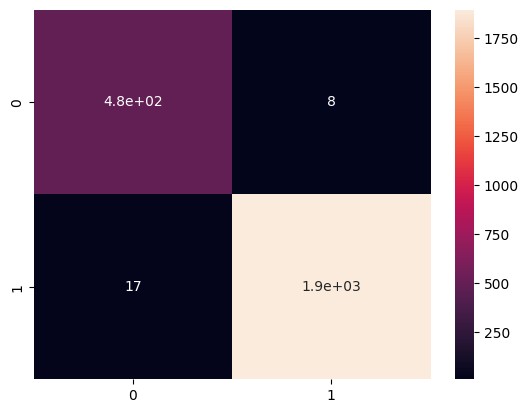

In [22]:
#cm = confusion_matrix(normalize='true', y_pred=o, y_true=target)
cm = confusion_matrix(y_pred=o, y_true=target)
sns.heatmap(cm, annot=True)
plt.show()

In [26]:
device = CudaDevice().get_device(force_cpu=False)

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
model = torch.load("drive/MyDrive/model_epoch_3.pt")

demo = pd.read_excel('/content/drive/My Drive/projeto classificacao de lancamento/dados/demo.xlsx')
novo_texto = demo.sample(1)['Histórico'].values[0]

model.eval()
with torch.no_grad():
  data = tokenizer.encode_plus(
    novo_texto,
    max_length=512,
    pad_to_max_length=True,
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_overflowing_tokens=False,
    truncation=True,
    return_tensors='pt')

  ids = data['input_ids'].to(device, dtype=torch.long)
  mask = data['attention_mask'].to(device, dtype=torch.long)

  otps = model(ids=ids, mask=mask)
  pred_proba = torch.softmax(otps, dim=1)

print(f'Texto: {novo_texto}')
print(f'Predição = Neg({pred_proba[0][0]:0.4f}), Pos({pred_proba[0][1]:0.4f})')

Existe(m) 1 GPU(s) disponíveis.
A GPU Tesla T4 será usada.
Texto: Destinado ao pagamento de Serviços Prestados á Secretaria de Saúde no  cargo de Medico Plantonista no Hospital Municipal durante o mês MARÇO/2024
Predição = Neg(0.0001), Pos(0.9999)


In [24]:
demo = pd.read_excel('/content/drive/My Drive/projeto classificacao de lancamento/dados/demo.xlsx')
demo.columns

Index(['Histórico'], dtype='object')